In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def autocov_est(vhat,j):
    if j >=0:
        T = len(vhat)
        v_t = vhat[j:T]
        v_tm1 = vhat[0:T-j]
        gamma_hat_j = np.dot(v_t.T,v_tm1)/T
        return gamma_hat_j
    else:
        T = len(vhat)
        v_t = vhat[-j:T]
        v_tm1 = vhat[0:T+j]
        gamma_hat_j = np.dot(v_t.T,v_tm1)/T
        return gamma_hat_j

In [3]:
def NW_band(vhat,c,p,q=2):
    n = len(vhat)
    T = len(vhat)
    if vhat.shape[1] == 1:
        nw_lag = c*(n**p)
        a_n = nw_lag
        f_q = 0
        f_0 = 0
        for j in range(-int(a_n),int(a_n)+1):
            f_q = f_q + (np.abs(j)**q)*autocov_est(vhat,j)
            f_0 = f_0 + autocov_est(vhat,j)

        a_hat_2 = (f_q/f_0)**2
        ST_NW = 2.6614*(T*a_hat_2)**(0.2) #bandwidth
        ST_NW = np.float(ST_NW)
        return ST_NW
    elif vhat.shape[1] == 2:
        nw_lag = c*(n**p)
        a_n = nw_lag
        f_q = 0
        f_0 = 0
        wp = np.array([[0,1]])
        w = wp.T
        for j in range(-int(a_n),int(a_n)+1):
            f_q = f_q + (np.abs(j)**q)*(np.dot(np.dot(wp,autocov_est(vhat,j)),w))
            f_0 = f_0 + (np.dot(np.dot(wp,autocov_est(vhat,j)),w))

        a_hat_2 = (f_q/f_0)**2
        ST_NW = 2.6614*(T*a_hat_2)**(0.2) #bandwidth
        ST_NW = np.float(ST_NW)
        return ST_NW

In [4]:
    def AD_band(vhat):
        vhat = np.copy(vhat)
        #vhat = np.copy(xuhat)
        if vhat.shape[1] == 1:
            pass
        elif vhat.shape[1] == 2:
            vhat = np.copy(np.reshape(vhat[:,1],(len(vhat[:,1]),1))) 

        T = len(vhat)

        vhat_t = np.copy(vhat[1:])
        vhat_tm1 = np.copy(vhat[:-1])
        y2 = np.copy(vhat_t)
        X2 = np.copy(vhat_tm1)
        rho_hat = np.linalg.inv(X2.transpose().dot(X2)).dot(X2.transpose()).dot(y2) #without constant
        #print (rho_hat)
        
        # Old restriction
        #if (np.abs(rho_hat-1) < 0.001) & (rho_hat>=1):
        #    rho_hat = 1.001
        #elif (np.abs(rho_hat-1) < 0.001) & (rho_hat<1):
        #    rho_hat = 0.999
        
        # New restriction
        if rho_hat > 1:
            rho_hat = 0.97

        alpha_hat_2 = (4*(rho_hat)**2)/((1-rho_hat)**4) #univariate version CLP
        ST = 2.6614*(T*alpha_hat_2)**(0.2) #bandwidth
        ST = np.float(ST)
        return (ST)

In [5]:
def Parzen(x):
    if 0<=np.abs(x)<=0.5:
        kx = 1-6*(x**2)+6*((np.abs(x))**3)
        return kx
    elif 0.5<=np.abs(x)<=1:
        kx = 2*((1-np.abs(x))**3)
        return kx
    else:
        kx = 0
        return kx

In [6]:
def LRV(vhat,c,p,q=2,band="NW"):
    if band == "NW":
        n = len(vhat)                                
        LRV = 0
        b_n = NW_band(vhat,c,p,q=2) # band is NW
        for j in range(-int(n),int(n)+1):
            LRV = LRV + Parzen(j/b_n)*autocov_est(vhat,j)
        return LRV    
    elif band == "AD":
        n = len(vhat)                                
        LRV = 0
        b_n = AD_band(vhat) #band is AD
        for j in range(-int(n),int(n)+1):
            LRV = LRV + Parzen(j/b_n)*autocov_est(vhat,j)
        return LRV

In [7]:
def newLRV(vhat,b_n):
    n = len(vhat)                                
    LRV = 0
    for j in range(-int(n),int(n)+1):
        LRV = LRV + Parzen(j/b_n)*autocov_est(vhat,j)
    return LRV    

In [8]:
def G_test(R,r,b,X,vhat,c,p,q=2,band="NW"):
    if band == "NW":
        j = np.dot(R,b)-r
        Xv = np.linalg.inv(np.dot(X.T,X))
        s = np.dot(np.dot(R,Xv),R.transpose())

        G_pre = np.dot(np.dot(j.transpose(),np.linalg.inv(s)),j)
        G_stat = G_pre/LRV(vhat,c,p,q=2,band="NW")
        G_stat = np.float(G_stat)
        return G_stat
    elif band == "AD":
        j = np.dot(R,b)-r
        #s = np.dot(np.dot(R,1/np.sum(x*x)),R.transpose())
        Xv = np.linalg.inv(np.dot(X.T,X))
        s = np.dot(np.dot(R,Xv),R.transpose())

        G_pre = np.dot(np.dot(j.transpose(),np.linalg.inv(s)),j)
        G_stat = G_pre/LRV(vhat,c,p,q=2,band="AD")
        G_stat = np.float(G_stat)
        return G_stat

In [9]:
def newG_test(R,r,b,X,vhat,b_n):
    j = np.dot(R,b)-r
    Xv = np.linalg.inv(np.dot(X.T,X))
    s = np.dot(np.dot(R,Xv),R.transpose())

    G_pre = np.dot(np.dot(j.transpose(),np.linalg.inv(s)),j)
    G_stat = G_pre/newLRV(vhat,b_n)
    G_stat = np.float(G_stat)
    return G_stat

In [10]:
def newH_test(R,r,b,X,vhat,b_n):
    n = len(vhat)
    j = np.dot(R,b)-r
    Xv = np.linalg.inv(np.dot(X.T,X))
    s = np.dot(R,Xv)
    nomega = n*newLRV(vhat,b_n)
    center = np.dot(np.dot(s,nomega),s.transpose())

    H_stat = np.dot(np.dot(j.transpose(),np.linalg.inv(center)),j)
    H_stat = np.float(H_stat)
    return H_stat

In [11]:
def H_test(R,r,b,X,vhat,c,p,q=2,band="NW"):
    if band == "NW":
        n = len(vhat)
        j = np.dot(R,b)-r
        Xv = np.linalg.inv(np.dot(X.T,X))
        s = np.dot(R,Xv)
        nomega = n*LRV(vhat,c,p,q=2,band="NW")
        center = np.dot(np.dot(s,nomega),s.transpose())

        H_stat = np.dot(np.dot(j.transpose(),np.linalg.inv(center)),j)
        H_stat = np.float(H_stat)
        return H_stat
        
    elif band == "AD":
        n = len(vhat)
        j = np.dot(R,b)-r
        Xv = np.linalg.inv(np.dot(X.T,X))
        s = np.dot(R,Xv)
        nomega = n*LRV(vhat,c,p,q=2,band="AD")
        center = np.dot(np.dot(s,nomega),s.transpose())

        H_stat = np.dot(np.dot(j.transpose(),np.linalg.inv(center)),j)
        H_stat = np.float(H_stat)
        return H_stat

In [12]:
def OU_p(t_0,t_end,length,k_u,mu,sigma_u):
    #nprn = np.random.seed(i+10)
    t = np.linspace(t_0,t_end,length) # define time axis
    dt = np.mean(np.diff(t))
    u = np.zeros(length)
    u0 = np.random.normal(loc=0.0,scale=1.0) # initial condition
    u[0] = 0

    drift = lambda u,t: k_u*(mu-u) # define drift term, google to learn about lambda
    diffusion = lambda u,t: sigma_u # define diffusion term
    noise = np.random.normal(loc=0.0,scale=1.0,size=length)*np.sqrt(dt) #define noise process

    # solve SDE
    for i in range(1,length):
        u[i] = u[i-1] + drift(u[i-1],i*dt)*dt + diffusion(u[i-1],i*dt)*noise[i]

    u = np.reshape(u, (len(u), 1))
    return u

In [37]:
s = np.random.normal(0, 1, 50)
print (s)
s = np.reshape(s, (50, 1))
print (s.shape)

[-0.7355032  -0.83663508  1.1790317   0.51452386  0.94568756 -0.06107109
  0.36070635  0.18535745  0.02723907 -0.33116323  0.39534001 -0.29598309
  0.2527487  -0.82204308  0.52409551 -0.19024743  2.27832885  0.86116768
 -1.61065767 -0.27774572  1.04427612  0.70949756 -0.52218439  0.83489156
  0.90597708 -1.70338088  0.87248627  1.02913158 -0.05117264 -0.36233121
  1.10891713 -1.13591463  1.92953279 -0.76609932 -0.35182134  0.72919048
  0.14107698 -1.34237564 -0.02151962 -0.84076702 -2.39549612 -0.73207037
 -0.17450289 -0.54977671 -0.86869847 -0.43888146 -0.28473115  0.77560949
  1.03763958 -1.21470432]
(50, 1)


In [34]:
u = OU_p(0,30,30*252,4,0,0.0097)
print (u)
print (u.shape)

[[ 0.        ]
 [-0.00010948]
 [-0.00089976]
 ...
 [-0.0006973 ]
 [-0.00095107]
 [-0.00013838]]
(7560, 1)


In [60]:

x = np.zeros((50,1))
eps = np.random.normal(0, 1, 50)
eps = np.reshape(eps, (50, 1))
for a in range (50-1):
    print (a)
    x[a+1,0] = x[a,0] + eps[a+1,0]
print (x)
print (eps)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
[[ 0.00000000e+00]
 [-7.15158325e-02]
 [ 6.70477599e-01]
 [-1.24341749e+00]
 [-6.60654359e-03]
 [ 1.39866610e+00]
 [ 5.27544248e-01]
 [ 8.82384582e-01]
 [ 5.64182655e-01]
 [ 1.44362505e-01]
 [ 4.36337879e-01]
 [ 3.79058073e-02]
 [ 1.49424260e-01]
 [ 2.11440539e+00]
 [ 2.07423217e+00]
 [ 1.06341853e+00]
 [ 1.60195344e-01]
 [-3.53731492e-01]
 [-4.87140073e-01]
 [-1.83654108e-01]
 [ 2.95606689e-02]
 [-6.25167212e-01]
 [-9.81099546e-02]
 [-5.54197993e-01]
 [-1.62185980e+00]
 [-9.57324135e-01]
 [-8.80148281e-01]
 [-9.53456689e-01]
 [-2.55868858e+00]
 [-2.25000612e+00]
 [-3.10752202e-01]
 [-5.67385531e-01]
 [-2.16993216e-02]
 [ 3.11848662e-01]
 [-4.01756374e-01]
 [-1.07121142e+00]
 [-2.53793929e+00]
 [-3.58418204e+00]
 [-3.22768415e+00]
 [-2.63990325e+00]
 [-2.39013353e+00]
 [-2.21578405e+00]
 [-3.90970339e+00]
 [-3.50393374e+00]
 [-3.69896685e+00]
 [-5.773

In [71]:
T = 100
replication = 1000
ku = np.linspace(0,6,5) + 0
kx = np.linspace(0,6,5) + 0
bnset = np.linspace(0,T,51) + 0
chi = np.zeros((2,5,5))
chi2 = np.zeros((2,5,5))
c1 = 0.26880
c2 = 0.98804
c3 = -0.04904
c4 = 5.13641
c5 = -2.37697
c6 = 0.15189
c7 = -2.17925
c8 = 3.06497
c9 = 0.22194
for q in range(len(bnset)-1):
    table_mean_AD = np.zeros((5,5))
    table_mean_NW = np.zeros((5,5))
    table_med_AD = np.zeros((5,5))
    table_med_NW = np.zeros((5,5))
    table_min_AD = np.zeros((5,5))
    table_min_NW = np.zeros((5,5))
    table_max_AD = np.zeros((5,5))
    table_max_NW = np.zeros((5,5))

    table_rej_AD = np.zeros((5,5))
    table_rej_NW = np.zeros((5,5))
    table_rej_FB = np.zeros((5,5))

    table_avgband_AD = np.zeros((5,5))
    table_avgband_NW = np.zeros((5,5))


    AD_set = [0]
    NW_set = [0]
    #fixedb_set = [0]

    for w in range(1):
        for d in range(1):
            AD_set = [0]
            NW_set = [0]
            #fixedb_set = [0]
            name1 = "band_AD"+str(w)+str(d)
            name2 = "band_NW"+str(w)+str(d)
            globals()[name1] = [0]
            globals()[name2] = [0]
            name3 = "stat_AD"+str(w)+str(d)
            name4 = "stat_NW"+str(w)+str(d)
            globals()[name3] = [0]
            globals()[name4] = [0]

            for i in range(replication):
                np.random.seed(i)
                #u = OU_p(0,30,30*252,ku[w],0,0.0097)
                #x = OU_p(0,30,30*252,kx[d],0,0.0998)
                
                #scenario 1
                u = np.random.normal(0, 1, T)
                u = np.reshape(u,(T,1))
                x = np.random.normal(0, 1, T)
                x = np.reshape(x,(T,1))
                
                #scenario 2
                #x = np.zeros((T,1))
                #eps = np.random.normal(0, 1, T)
                #eps = np.reshape(eps, (T, 1))
                #for a in range (T-1):
                #    x[a+1,0] = x[a,0] + eps[a+1,0]
                #u = np.random.normal(0, 1, T)
                #u = np.reshape(u,(T,1))

                #####
                #u = np.copy(u[::63]) #quaterly
                #x = np.copy(x[::63])

                b0 = 0
                b1 = 1
                y = b0 + b1*x + u
                nu = len(x)
                cons = np.ones((nu,1))
                X = np.hstack((cons,x))
                coeffs = np.linalg.inv(X.transpose().dot(X)).dot(X.transpose()).dot(y)

                X_hat = np.dot(X,coeffs)
                uhat = y - X_hat   
                #vhat = np.copy(uhat) #G-test
                vhat = np.copy(X*uhat) #H-test

                R = np.array([[1, 0], [0, 1]])
                r = np.array([[0],[1]])

                b_n = bnset[q+1]
                #AD1 = newG_test(R,r,coeffs,X,vhat,b_n)
                AD1 = newH_test(R,r,coeffs,X,vhat,b_n)


                #AD1 = G_test(R,r,coeffs,X,vhat,c=1,p=4/25,q=2,band="AD")
                AD_set.append(AD1)
                globals()[name3].append(AD1)
                #AD_b = AD_band(vhat)
                #globals()[name1].append(AD_b)
                #fb = 1.2816 + 1.5184*b_n + 1.0821*(b_n**2) - 0.0660*(b_n**3)
                #fixedb_set.append(fb)

                #NW1 = G_test(R,r,coeffs,X,vhat,c=5.5*(1/100)**(7/25),p=7/25,q=2,band="NW")
                #NW_set.append(NW1)
                #globals()[name4].append(NW1)
                #NW_b = NW_band(vhat,c=5.5*(1/100)**(7/25),p=7/25,q=2)
                #globals()[name2].append(NW_b)
            table_med_AD[w,d] = np.median(AD_set[1:])
            #table_med_NW[w,d] = np.median(NW_set[1:])
            table_mean_AD[w,d] = np.mean(AD_set[1:])
            #table_mean_NW[w,d] = np.mean(NW_set[1:])
            table_min_AD[w,d] = np.min(AD_set[1:])
            #table_min_NW[w,d] = np.min(NW_set[1:])
            table_max_AD[w,d] = np.max(AD_set[1:])
            #table_max_NW[w,d] = np.max(NW_set[1:])
            table_rej_AD[w,d] = sum(x > 5.9915 for x in AD_set[1:])/len(AD_set[1:])
            table_rej_FB[w,d] = sum(x > 5.9915 + c1*(b_n/T*5.9915) + c2*((b_n/T)*(5.9915**2)) + c3*((b_n/T)*(5.9915**3)) + c4*(((b_n/T)**2)*5.9915) + c5*(((b_n/T)**2)*(5.9915**2)) + c6*(((b_n/T)**2)*(5.9915**3)) + c7*(((b_n/T)**3)*(5.9915**1)) + c8*(((b_n/T)**3)*(5.9915**2)) + c9*(((b_n/T)**3)*(5.9915**3)) for x in AD_set[1:])/len(AD_set[1:])
            print ("band:",b_n/T, "rej prob:", table_rej_FB[w,d])
            #table_rej_NW[w,d] = sum(y > 5.9915 for y in NW_set[1:])/(i+1)
            #table_avgband_AD[w,d] = np.mean(globals()[name1][1:])
            #table_avgband_NW[w,d] = np.mean(globals()[name2][1:])
            #AD_set = [0]
            #NW_set = [0]
            
    chi= np.append(chi,[table_rej_AD],axis=0)
    chi2= np.append(chi2,[table_rej_FB],axis=0)

band: 0.02 rej prob: 0.059
band: 0.04 rej prob: 0.056
band: 0.06 rej prob: 0.057
band: 0.08 rej prob: 0.049
band: 0.1 rej prob: 0.05
band: 0.12 rej prob: 0.048
band: 0.14 rej prob: 0.047
band: 0.16 rej prob: 0.046
band: 0.18 rej prob: 0.041
band: 0.2 rej prob: 0.04
band: 0.22 rej prob: 0.041
band: 0.24 rej prob: 0.037
band: 0.26 rej prob: 0.033
band: 0.28 rej prob: 0.032
band: 0.3 rej prob: 0.029
band: 0.32 rej prob: 0.029
band: 0.34 rej prob: 0.031
band: 0.36 rej prob: 0.029
band: 0.38 rej prob: 0.027
band: 0.4 rej prob: 0.025
band: 0.42 rej prob: 0.025
band: 0.44 rej prob: 0.024
band: 0.46 rej prob: 0.023
band: 0.48 rej prob: 0.02
band: 0.5 rej prob: 0.02
band: 0.52 rej prob: 0.022
band: 0.54 rej prob: 0.021
band: 0.56 rej prob: 0.019
band: 0.58 rej prob: 0.017
band: 0.6 rej prob: 0.018
band: 0.62 rej prob: 0.019
band: 0.64 rej prob: 0.018
band: 0.66 rej prob: 0.017
band: 0.68 rej prob: 0.015
band: 0.7 rej prob: 0.015
band: 0.72 rej prob: 0.015
band: 0.74 rej prob: 0.015
band: 0.76 r

In [62]:
T = 1000
bnset = np.linspace(0,T,51) + 0
for q in range(len(bnset)-1):
    b_n = bnset[q+1]
    dd =5.9915 + c1*(b_n/T*5.9915) + c2*((b_n/T)*(5.9915**2)) + c3*((b_n/T)*(5.9915**3)) + c4*(((b_n/T)**2)*5.9915) + c5*(((b_n/T)**2)*(5.9915**2)) + c6*(((b_n/T)**2)*(5.9915**3)) + c7*(((b_n/T)**3)*(5.9915**1)) + c8*(((b_n/T)**3)*(5.9915**2)) + c9*(((b_n/T)**3)*(5.9915**3))
    print (b_n/T,"cv-ftn:",round(dd,4))

0.02 cv-ftn: 6.5145
0.04 cv-ftn: 7.027
0.06 cv-ftn: 7.5359
0.08 cv-ftn: 8.0481
0.1 cv-ftn: 8.5705
0.12 cv-ftn: 9.1102
0.14 cv-ftn: 9.674
0.16 cv-ftn: 10.269
0.18 cv-ftn: 10.902
0.2 cv-ftn: 11.5801
0.22 cv-ftn: 12.31
0.24 cv-ftn: 13.0989
0.26 cv-ftn: 13.9536
0.28 cv-ftn: 14.8811
0.3 cv-ftn: 15.8884
0.32 cv-ftn: 16.9823
0.34 cv-ftn: 18.1698
0.36 cv-ftn: 19.4579
0.38 cv-ftn: 20.8536
0.4 cv-ftn: 22.3637
0.42 cv-ftn: 23.9952
0.44 cv-ftn: 25.755
0.46 cv-ftn: 27.6502
0.48 cv-ftn: 29.6876
0.5 cv-ftn: 31.8742
0.52 cv-ftn: 34.217
0.54 cv-ftn: 36.7228
0.56 cv-ftn: 39.3986
0.58 cv-ftn: 42.2515
0.6 cv-ftn: 45.2882
0.62 cv-ftn: 48.5158
0.64 cv-ftn: 51.9413
0.66 cv-ftn: 55.5714
0.68 cv-ftn: 59.4133
0.7 cv-ftn: 63.4739
0.72 cv-ftn: 67.76
0.74 cv-ftn: 72.2787
0.76 cv-ftn: 77.0369
0.78 cv-ftn: 82.0415
0.8 cv-ftn: 87.2995
0.82 cv-ftn: 92.8178
0.84 cv-ftn: 98.6034
0.86 cv-ftn: 104.6632
0.88 cv-ftn: 111.0041
0.9 cv-ftn: 117.6332
0.92 cv-ftn: 124.5574
0.94 cv-ftn: 131.7835
0.96 cv-ftn: 139.3186
0.98 cv-ftn:

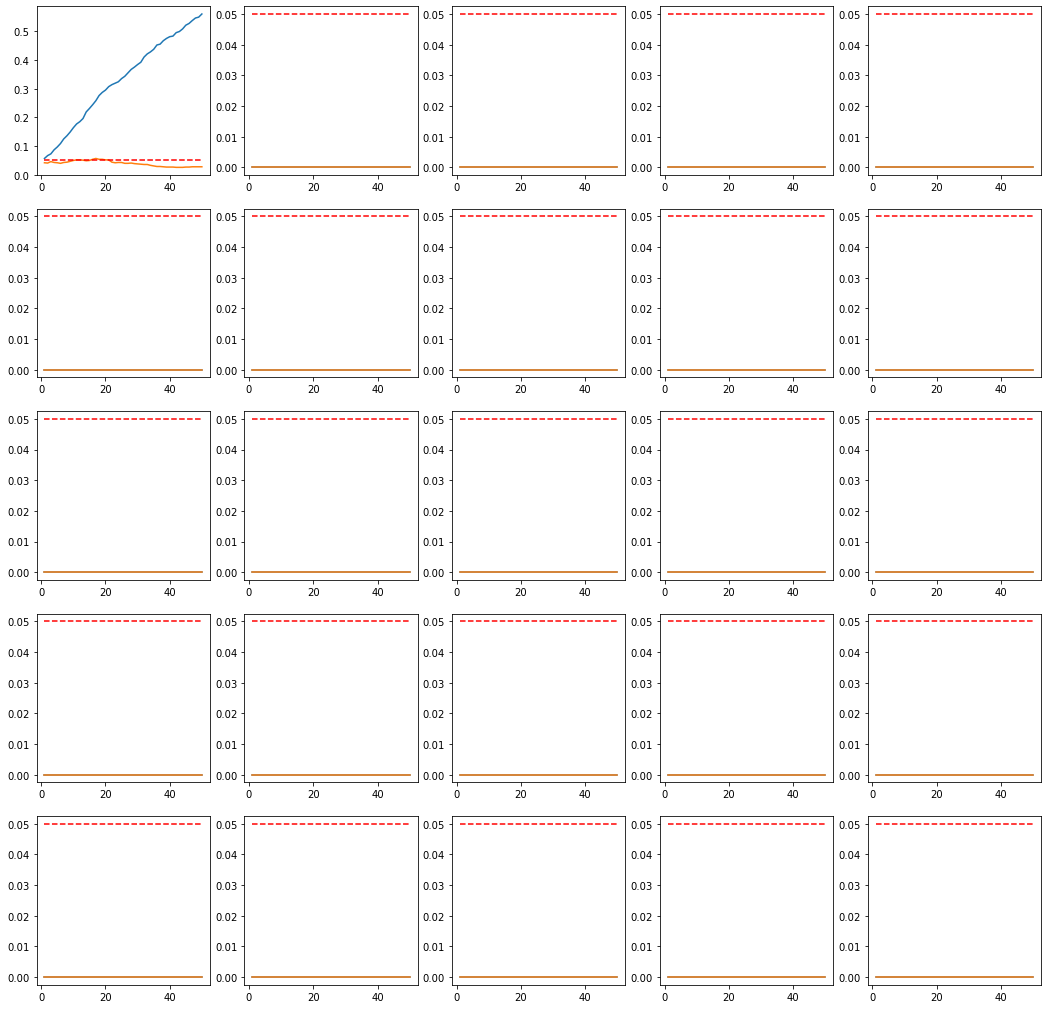

In [21]:
#fig = plt.figure()

plt.subplots(nrows=5, ncols=5,figsize=(18,18))

for w in range(5):
    for d in range(5):
        plt.subplot(5, 5, 5*(w)+d+1)
        y = chi[2:,w,d]
        x = np.linspace(0,T,51) + 0
        x = x[1:]
        plt.plot(x, y)
        y2 = chi2[2:,w,d]
        plt.plot(x,y2)
        y3 = np.zeros((y.shape)) +0.05
        plt.plot(x,y3,'r--')
plt.savefig("subplot_all.eps",dpi=600)
plt.show()

In [36]:
plt.clf()
for w in range(1):
    for d in range(1):
        y = chi[2:,w,d]
        yy = chi2[2:,w,d]
        x = np.linspace(0,T,51) + 0
        x = x[1:]
        plt.rcParams["figure.figsize"]=(9, 6)
        plt.plot(x, y, label="Chi-square")
        plt.plot(x, yy, label="Fixed-b")
        y2 = np.zeros((y.shape)) +0.05
        y3 = np.zeros((y.shape)) +0.00
        plt.plot(x,y2,'r--',label="0.05 level")
        plt.plot(x,y3,'r--',label="0.00 level")
        #plt.figure(figsize=(100, 100))
        plt.xticks(np.arange(0, max(x), T/10))
        plt.xlabel("Bandwidth", fontsize=15)
        plt.ylabel("Rejection Probabilities", fontsize=15)
        plt.title('$x_{t}$~N(0,1), $u_{t}$~N(0,1) '  +"(Sample size = %d, " %T + 'H-test)', fontsize=15)
        plt.legend(loc="upper center", fontsize=12)
        plt.savefig("simH1_" +"%d.jpg"%T,dpi=600)
        plt.savefig("simH1_" +"%d.eps"%T,dpi=600)
        plt.clf()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 648x432 with 0 Axes>

In [51]:
plt.clf()
for w in range(1):
    for d in range(1):
        y = chi[2:,w,d]
        yy = chi2[2:,w,d]
        x = np.linspace(0,T,51) + 0
        x = x[1:]
        plt.rcParams["figure.figsize"]=(9, 6)
        plt.plot(x, y, label="Chi-square")
        plt.plot(x, yy, label="Fixed-b")
        y2 = np.zeros((y.shape)) +0.05
        y3 = np.zeros((y.shape)) +0.00
        plt.plot(x,y2,'r--',label="0.05 level")
        plt.plot(x,y3,'r--',label="0.00 level")
        #plt.figure(figsize=(100, 100))
        plt.xticks(np.arange(0, max(x), T/10))
        plt.xlabel("Bandwidth", fontsize=15)
        plt.ylabel("Rejection Probabilities", fontsize=15)
        plt.title('$x_{t}$ = $x_{t-1}$ + $\epsilon_{t}$, $u_{t}$~N(0,1) ' +"(Sample size = %d, " %T + 'H-test)', fontsize=15)
        plt.legend(loc="upper center", fontsize=12)
        plt.savefig("simH2_" +"%d.jpg" %T,dpi=600)
        plt.savefig("simH2_" +"%d.eps" %T,dpi=600)
        plt.clf()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 648x432 with 0 Axes>